In [8]:
# Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
from random import shuffle
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img, resample_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi, plot_epi

In [9]:
# Set working directory
os.chdir('/home/uziel/DISS')
test_flag = 1

In [10]:
#List all sequences per subject
if test_flag:
    root = './data/ISLES2017/testing'
else:
    root = './data/ISLES2017/training'

subjects_paths = sorted(os.listdir(root))
channels_per_subject = dict() # groups relevant sequences per subject
for i in range(len(subjects_paths)):
    s_path = os.path.join(root, subjects_paths[i])
    channels_per_subject[i] = [y
                               for x in os.walk(s_path)
                               for y in
                               glob(os.path.join(x[0], '*ADC*.nii')) or
                               glob(os.path.join(x[0], '*MTT*.nii')) or
                               glob(os.path.join(x[0], '*rCBF*.nii')) or
                               glob(os.path.join(x[0], '*rCBV*.nii')) or
                               glob(os.path.join(x[0], '*Tmax*.nii')) or
                               glob(os.path.join(x[0], '*TTP*.nii')) or
                               glob(os.path.join(x[0], '*OT*.nii'))
                              ]


In [4]:
# Resample images to same voxel size
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'

# define template path
template_path = './data/MNI152_T1_1mm_brain.nii.gz'
# define downsample factor
dF = 0.7

# remove and create dir for processed data
if os.path.exists(root): shutil.rmtree(root)
os.makedirs(root)

# load template image
template = nib.load(template_path)

for subject in channels_per_subject.keys():
    # create subdirectory per subject
    subject_root = os.path.join(root, str(subject))
    os.mkdir(subject_root)
    
    subject_imgs = []
    # Resample img to match template (1mm voxel size / dF)
    for channel_file in channels_per_subject[subject]:
        if 'OT' in channel_file:            
            # label must be resampled using nearest neighbour
            resampled_img = resample_img(channel_file,
                                         template.affine[:3,:3]/dF,
                                         interpolation='nearest')
        else:
            resampled_img = resample_img(channel_file,
                                         template.affine[:3,:3]/dF,
                                         interpolation='continuous')

        subject_imgs.append([resampled_img, channel_file])
        
    # compute subject brain mask given all original channels (ignore label channel)
    mask = compute_background_mask([y for x,y in subject_imgs if not 'OT' in y])
    # dilate mask to adjust better to boundaries
    dilated_mask_data = ndimage.binary_dilation(mask.dataobj, iterations=2)
    mask = nib.nifti1.Nifti1Image(mask.dataobj.astype(np.int32), mask.affine)
    # resample mask to match template
    mask = resample_img(mask,
                        template.affine[:3,:3]/dF,
                        interpolation='nearest')
    # dilate mask to adjust better to boundaries
    dilated_mask_data = ndimage.binary_dilation(mask.dataobj)
    mask = nib.nifti1.Nifti1Image(mask.dataobj.astype(np.int32), mask.affine)
    # save mask
    nib.save(mask, os.path.join(subject_root, 'mask.nii.gz'))
   
    # normalize each image within mask and save
    for img, channel_file in subject_imgs:
        # don't try to normalize label channel
        if 'OT' not in channel_file:
            # get data within mask
            temp_data = img.dataobj * mask.dataobj
            # compute mean and variance of non-zero values
            mean = np.mean(temp_data[np.nonzero(temp_data)])
            var = np.var(temp_data[np.nonzero(temp_data)])
            # substract mean and divide by variance all non-zero valuess
            temp_data[np.nonzero(temp_data)] = (temp_data[np.nonzero(temp_data)] - mean) / var
            # build normalised image with normalised data and unmodified affine
            img = nib.nifti1.Nifti1Image(temp_data.astype(np.float32), img.affine)
        else:
            img = nib.nifti1.Nifti1Image(img.get_data().astype(np.int32), img.affine)

        # save image
        file_name = os.path.basename(channel_file)
        nib.save(img, os.path.join(subject_root, file_name) + '.gz')
      
    print("Subject " + str(subject) + " finished.")


/home/uziel/anaconda2/envs/diss/lib/python2.7/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


Subject 0 finished.
Subject 1 finished.
Subject 2 finished.
Subject 3 finished.
Subject 4 finished.
Subject 5 finished.
Subject 6 finished.
Subject 7 finished.
Subject 8 finished.
Subject 9 finished.
Subject 10 finished.
Subject 11 finished.
Subject 12 finished.
Subject 13 finished.
Subject 14 finished.
Subject 15 finished.
Subject 16 finished.
Subject 17 finished.
Subject 18 finished.
Subject 19 finished.
Subject 20 finished.
Subject 21 finished.
Subject 22 finished.
Subject 23 finished.
Subject 24 finished.
Subject 25 finished.
Subject 26 finished.
Subject 27 finished.
Subject 28 finished.
Subject 29 finished.
Subject 30 finished.
Subject 31 finished.
Subject 32 finished.
Subject 33 finished.
Subject 34 finished.
Subject 35 finished.
Subject 36 finished.
Subject 37 finished.
Subject 38 finished.
Subject 39 finished.
Subject 40 finished.
Subject 41 finished.
Subject 42 finished.


In [11]:
def data_to_file(data, path):
    out = open(path, "w")
    for line in data:
        print >> out, line
    out.close()

In [12]:
# Generate files listing all images per channel
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'
    
channels = {}
# channels - sequences os.path.join('../../../../../../', x) needed for deepmedic
channels['Channels_ADC'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_MTT'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_rCBF'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_rCBV'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_Tmax'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_TTP'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                                   if 'clone' not in y
                                  ])
# labels
channels['GtLabels'] = sorted([os.path.join('../../../../../../', y)
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                               if 'clone' not in y
                              ])
# masks
channels['RoiMasks'] = sorted([os.path.join('../../../../../../', y)
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], 'mask.nii.gz'))
                               if 'clone' not in y
                              ])


In [13]:
####################################################################
##### FILES FOR DM_V0 (BASELINE) AND TRANSFER LEARNING VARIANT #####
####################################################################
# set base config path
root_base = './ischleseg/deepmedic/versions/DM_V0_base'
root_base_transfer = './ischleseg/deepmedic/versions/DM_V0_transfer_base'

# number of train, validation and test sets
n_set = 10
for i in range(n_set):
    # set and make model variant dir
    s_path = os.path.join(os.path.dirname(root_base), 'DM_V0_' + str(i))
    s_path_transfer = os.path.join(os.path.dirname(root_base_transfer), 'DM_V0_transfer_' + str(i))
    # copy contents from base
    if not os.path.exists(s_path): shutil.copytree(root_base, s_path)
    if not os.path.exists(s_path_transfer): shutil.copytree(root_base_transfer, s_path_transfer)
        
    if test_flag:
        
        test_path = os.path.join(s_path, 'configFiles/test')
        test_path_transfer = os.path.join(s_path_transfer, 'configFiles/test')
        
        if not os.path.exists(test_path): os.makedirs(test_path)
        if not os.path.exists(test_path_transfer): os.makedirs(test_path_transfer)
            
        for name, files in channels.iteritems():
            # save test channel files
            data_to_file(files, os.path.join(test_path, 'test' + name + '.cfg'))
            data_to_file(files, os.path.join(test_path_transfer, 'test' + name + '.cfg'))

        # save names of predictions
        names = ['pred_ISLES2017_' + os.path.basename(x).split('.')[-3] for x in channels['Channels_ADC']]
        data_to_file(names, os.path.join(test_path, 'testNamesOfPredictions.cfg'))
        data_to_file(names, os.path.join(test_path_transfer, 'testNamesOfPredictions.cfg'))
        
    else:
        
        # set paths for storing channel config files
        train_path = os.path.join(s_path, 'configFiles/train')
        train_path_transfer = os.path.join(s_path_transfer, 'configFiles/train')
        validation_path = os.path.join(s_path, 'configFiles/validation')
        validation_path_transfer = os.path.join(s_path_transfer, 'configFiles/validation')

        if not os.path.exists(train_path): os.makedirs(train_path)
        if not os.path.exists(train_path_transfer): os.makedirs(train_path_transfer)
        if not os.path.exists(validation_path): os.makedirs(validation_path)
        if not os.path.exists(validation_path_transfer): os.makedirs(validation_path_transfer)

        # train and validation division point
        train_val_divison = int(np.floor(len(channels['Channels_ADC']) * 0.8))

        # random subject indices
        indices = range(len(channels['Channels_ADC']))
        random.shuffle(indices)
        
        for name, files in channels.iteritems():
            # save train channel files
            data_to_file([files[i] for i in indices[:train_val_divison]], os.path.join(train_path, 'train' + name + '.cfg'))
            data_to_file([files[i] for i in indices[:train_val_divison]], os.path.join(train_path_transfer, 'train' + name + '.cfg'))
            # save validation channel files
            data_to_file([files[i] for i in indices[train_val_divison:]], os.path.join(validation_path, 'validation' + name + '.cfg'))
            data_to_file([files[i] for i in indices[train_val_divison:]], os.path.join(validation_path_transfer, 'validation' + name + '.cfg'))


        # save names of predictions
        names = ['SMIR.ischleseg.' + os.path.basename(x).split('.')[-3]
                 for x in [channels['Channels_MTT'][i] for i in indices[train_val_divison:]]]
        data_to_file(names, os.path.join(validation_path, 'validationNamesOfPredictions.cfg'))
        data_to_file(names, os.path.join(validation_path_transfer, 'validationNamesOfPredictions.cfg'))

# modelConfig,cfg, trainConfig.cfg and testConfig.cfg must be added and modified manually.


Subject: 11. Channel: Channels_Tmax. Shape: (172, 188, 124)
Subject: 11. Channel: Channels_TTP. Shape: (172, 188, 124)
Subject: 11. Channel: Channels_rCBV. Shape: (172, 188, 124)
Subject: 11. Channel: Channels_ADC. Shape: (172, 188, 124)
Subject: 11. Channel: Channels_rCBF. Shape: (172, 188, 124)
Subject: 11. Channel: Channels_MTT. Shape: (172, 188, 124)


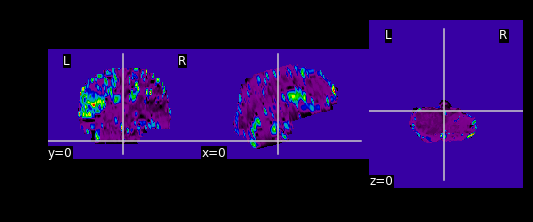

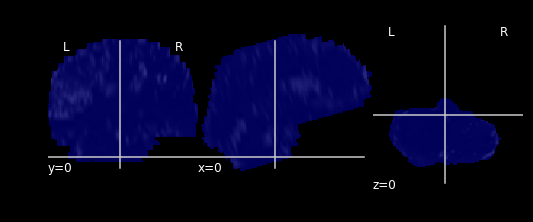

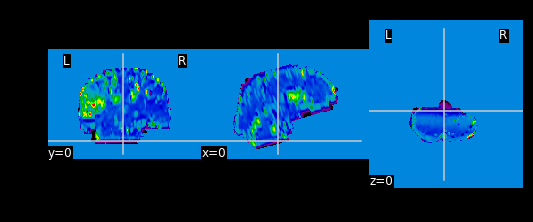

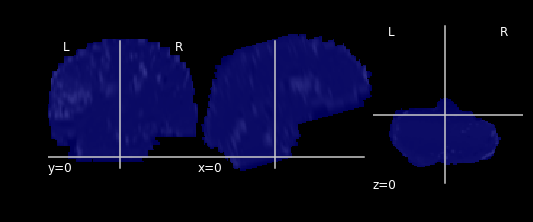

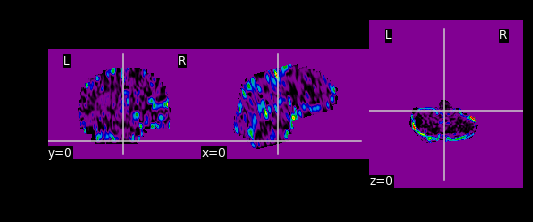

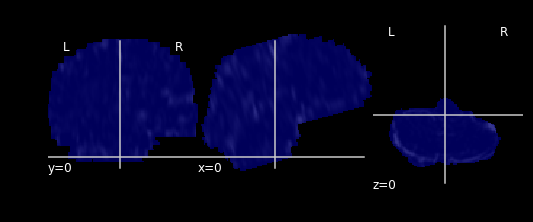

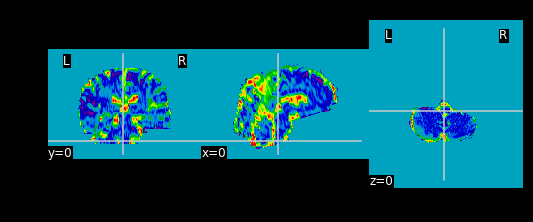

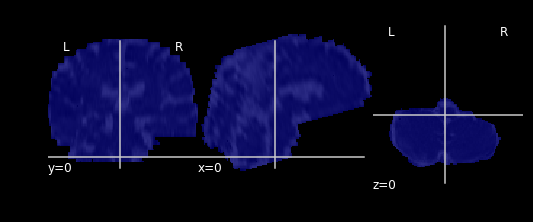

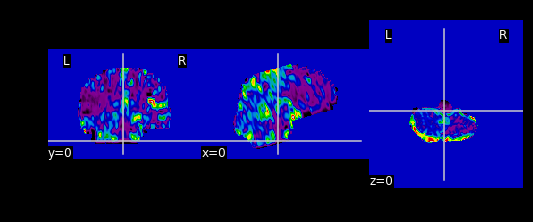

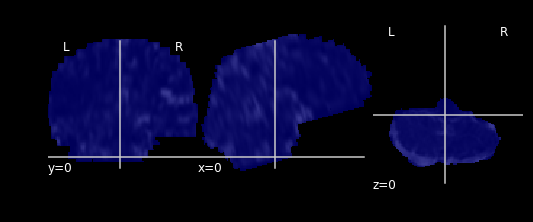

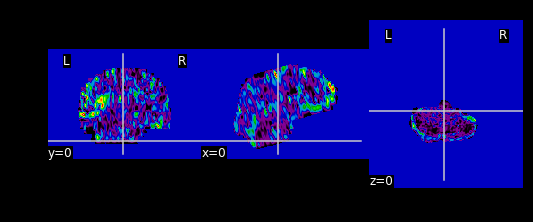

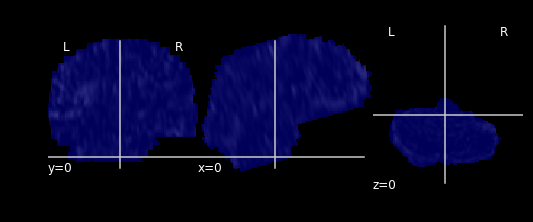

In [14]:
####################################
##### TEST PREPROCESSING FILES #####
####################################

# Generate files listing all images per channel
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'
    
channels = {}
channels['Channels_ADC'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_MTT'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_rCBF'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_rCBV'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_Tmax'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_TTP'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                                   if 'clone' not in y
                                  ])
# labels
channels['GtLabels'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                               if 'clone' not in y
                              ])
# masks
channels['RoiMasks'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], 'mask.nii.gz'))
                               if 'clone' not in y
                              ])

# take 5 random subjects and check their images
indices = range(len(channels['Channels_ADC']))

# load a random channel of subject i
subject = random.choice(indices)
for channel in channels.keys():
    if 'Mask' in channel or 'Labels' in channel:
        continue
    img = nib.load(channels[channel][subject])
    mask = nib.load(channels['RoiMasks'][subject])

    print('Subject: ' + str(subject) + '. Channel: ' + str(channel) + '. Shape: ' + str(img.shape))
    plot_epi(img, cut_coords=(0,0,0)) # plot_epi(img, cut_coords=(0,0,0)) -> use to see co-registered channels per subject
    plot_roi(mask, img, cut_coords=(0,0,0))
    
#for i in indices:
#    print('Subject index: ' + str(i))
#    plot_roi(nib.load(channels['RoiMasks'][i]), nib.load(channels['Channels_ADC'][i]), cut_coords=(0,0,0))